In [2]:
# Install any required packages
!pip install torch torchvision pandas matplotlib


In [3]:
import zipfile
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [6]:
# Unzip your DeepWriting dataset zip file
zip_path = '/content/deepwriting_dataset.zip'  # path to your uploaded zip
extract_path = '/content/deepwriting_data'

if not os.path.exists(extract_path):
    print("Unzipping dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Dataset unzipped!")
else:
    print("✅ Dataset already unzipped!")


✅ Dataset already unzipped!


In [7]:
# Define LSTM model for handwriting generation
class HandwritingLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=256, num_layers=3, output_size=3):
        super(HandwritingLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden


In [8]:

from torch.utils.data import random_split

# Load DeepWriting dataset
npz_files = [f for f in os.listdir(extract_path) if f.endswith('.npz')]
assert len(npz_files) > 0, "No .npz file found!"

npz_path = os.path.join(extract_path, npz_files[0])
data = np.load(npz_path, allow_pickle=True)

print("Keys in dataset:", data.files)

# DeepWriting dataset uses 'strokes'
raw_strokes = data['strokes']  # List of arrays
print(f"Number of stroke samples: {len(raw_strokes)}")

stroke_min = data['min']   # shape (3,)
stroke_max = data['max']   # shape (3,)

# Normalize strokes to [-1, 1]
normalized_strokes = []
for stroke in raw_strokes:
    norm = 2 * (stroke - stroke_min) / (stroke_max - stroke_min) - 1
    normalized_strokes.append(norm)

print(f"Example stroke shape after normalization: {normalized_strokes[0].shape}")

# Create x (input) and y (target) sequences
x_data = []
y_data = []

for seq in normalized_strokes:
    if len(seq) > 1:  # only keep sequences with at least 2 points
        x = seq[:-1, :]  # all except last point
        y = seq[1:, :]   # all except first point
        x_data.append(torch.tensor(x, dtype=torch.float32))
        y_data.append(torch.tensor(y, dtype=torch.float32))

print(f"Prepared {len(x_data)} sequences for training/validation.")

# Optionally, you can now split into train/valid
dataset = list(zip(x_data, y_data))

train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

print(f"Train set size: {len(train_dataset)}, Validation set size: {len(valid_dataset)}")


Keys in dataset: ['subject_labels', 'eoc_labels', 'alphabet', 'strokes', 'eow_labels', 'char_labels', 'word_labels', 'max', 'min', 'soc_labels', 'mean', 'texts', 'std', 'preprocessing', 'sow_labels']
Number of stroke samples: 34577
Example stroke shape after normalization: (326, 3)
Prepared 34577 sequences for training/validation.
Train set size: 31119, Validation set size: 3458


In [9]:
# Prepare DataLoader using the manually split dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)

print("✅ DataLoaders ready!")


✅ DataLoaders ready!


In [10]:
import torch.nn.utils.rnn as rnn_utils

# Custom collate function for padding sequences of variable lengths
def collate_fn(batch):
    # Separate the batch into inputs and targets
    inputs, targets = zip(*batch)

    # Pad sequences in the batch
    inputs_padded = rnn_utils.pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = rnn_utils.pad_sequence(targets, batch_first=True, padding_value=0)

    return inputs_padded, targets_padded

# Create train and validation loaders with padding
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=64, collate_fn=collate_fn)

print("✅ DataLoaders with padding ready!")


✅ DataLoaders with padding ready!


In [11]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming you have a model class HandwritingLSTM
model = HandwritingLSTM().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression problem
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Function to calculate pen-state prediction accuracy
def pen_state_accuracy(pred, target):
    # Extract pen state from 3rd channel (pen-up/down)
    pred_pen = (pred[:, :, 2] > 0.5).float()  # Predicted pen state
    true_pen = (target[:, :, 2] > 0.5).float()  # True pen state
    correct = (pred_pen == true_pen).float().mean()  # Accuracy
    return correct.item()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        pred, _ = model(xb)  # Forward pass
        loss = criterion(pred, yb)  # Compute loss
        loss.backward()  # Backpropagate
        optimizer.step()  # Update weights

        train_loss += loss.item()
        train_acc += pen_state_accuracy(pred, yb)

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for xb, yb in valid_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred, _ = model(xb)  # Forward pass
            loss = criterion(pred, yb)  # Compute loss
            valid_loss += loss.item()
            valid_acc += pen_state_accuracy(pred, yb)

    valid_loss /= len(valid_loader)
    valid_acc /= len(valid_loader)

    print(f"Epoch [{epoch+1}/{epochs}]  Train Loss: {train_loss:.6f}  Valid Loss: {valid_loss:.6f}  |  Train Acc: {train_acc:.4f}  Valid Acc: {valid_acc:.4f}")

# Save the trained model
torch.save(model.state_dict(), "/content/handwriting_model.pth")
print("✅ Model saved as handwriting_model.pth")


Epoch [1/10]  Train Loss: 0.048378  Valid Loss: 0.038780  |  Train Acc: 0.9700  Valid Acc: 0.9695
Epoch [2/10]  Train Loss: 0.038207  Valid Loss: 0.039041  |  Train Acc: 0.9700  Valid Acc: 0.9695
Epoch [3/10]  Train Loss: 0.037797  Valid Loss: 0.037601  |  Train Acc: 0.9699  Valid Acc: 0.9695
Epoch [4/10]  Train Loss: 0.037994  Valid Loss: 0.038645  |  Train Acc: 0.9699  Valid Acc: 0.9695
Epoch [5/10]  Train Loss: 0.037518  Valid Loss: 0.037560  |  Train Acc: 0.9700  Valid Acc: 0.9695
Epoch [6/10]  Train Loss: 0.036927  Valid Loss: 0.037736  |  Train Acc: 0.9700  Valid Acc: 0.9695
Epoch [7/10]  Train Loss: 0.036594  Valid Loss: 0.036783  |  Train Acc: 0.9699  Valid Acc: 0.9695
Epoch [8/10]  Train Loss: 0.036262  Valid Loss: 0.037040  |  Train Acc: 0.9699  Valid Acc: 0.9695
Epoch [9/10]  Train Loss: 0.036116  Valid Loss: 0.036390  |  Train Acc: 0.9699  Valid Acc: 0.9695
Epoch [10/10]  Train Loss: 0.035954  Valid Loss: 0.036133  |  Train Acc: 0.9699  Valid Acc: 0.9695
✅ Model saved as ha

In [12]:
# Load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = HandwritingLSTM().to(device)
model.load_state_dict(torch.load("/content/handwriting_model.pth", map_location=device))
model.eval()

print("✅ Model loaded and ready for testing!")


✅ Model loaded and ready for testing!


In [25]:
# Pick a random sample from validation dataset
import random

sample_idx = random.randint(0, len(valid_dataset) - 1)
input_stroke, target_stroke = valid_dataset[sample_idx]

# Add batch dimension
input_stroke = input_stroke.unsqueeze(0).to(device)  # Shape: (1, seq_len, 3)
target_stroke = target_stroke.unsqueeze(0).to(device)

print(f"✅ Picked sample index {sample_idx} for testing!")


✅ Picked sample index 3259 for testing!


In [26]:
# Predict
with torch.no_grad():
    pred_stroke, _ = model(input_stroke)

print(f"✅ Predicted stroke shape: {pred_stroke.shape}")


✅ Predicted stroke shape: torch.Size([1, 307, 3])


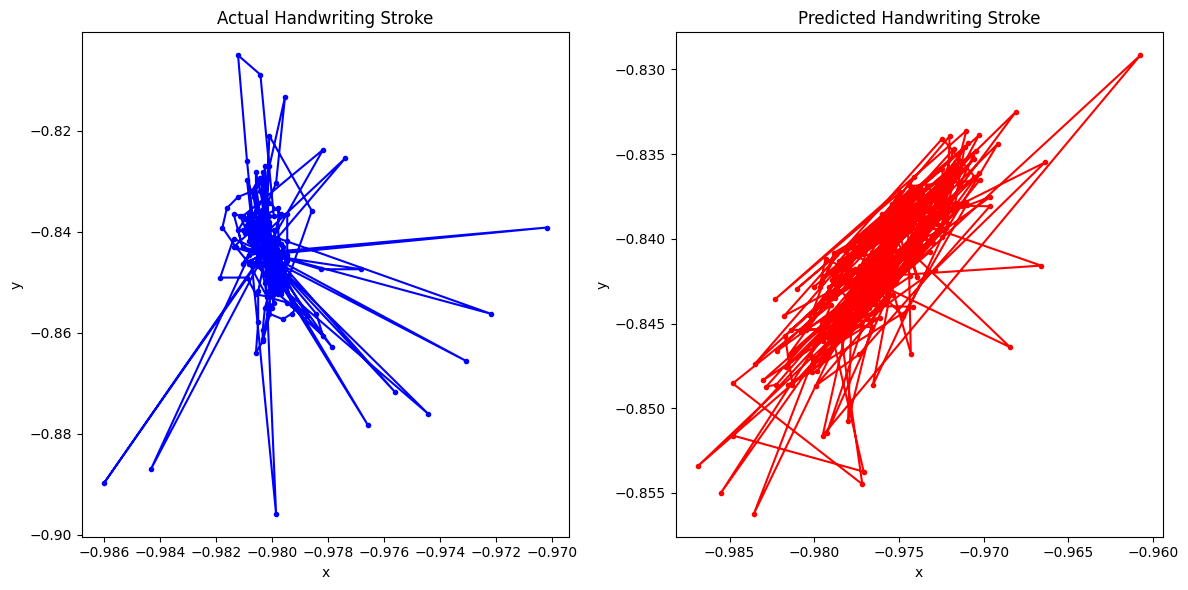

In [27]:
import matplotlib.pyplot as plt

# Move tensors to CPU
pred_stroke = pred_stroke.squeeze(0).cpu()
target_stroke = target_stroke.squeeze(0).cpu()

# Plot actual vs predicted
plt.figure(figsize=(12, 6))

# Actual
plt.subplot(1, 2, 1)
plt.plot(target_stroke[:, 0], target_stroke[:, 1], 'b.-')
plt.title("Actual Handwriting Stroke")
plt.xlabel("x")
plt.ylabel("y")

# Predicted
plt.subplot(1, 2, 2)
plt.plot(pred_stroke[:, 0], pred_stroke[:, 1], 'r.-')
plt.title("Predicted Handwriting Stroke")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()
